In [1]:
from keras import applications,optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model 

from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, warnings
from keras.layers import Dropout, Flatten, Dense

from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D

from keras_squeezenet import SqueezeNet

Using TensorFlow backend.


In [2]:
import shutil,os
import pandas as pd
import yaml
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
with open('sim-data-capture/sim_data_large.yaml', 'r') as f:
    df = pd.io.json.json_normalize(yaml.load(f))

def parse_values(val):

    if len(val) == 0:
        return 'noColor'
    else:
        return (val[0]['class'])
    
df['color'] = df.annotations.map(parse_values)
df.filename = df.filename.str.replace('sim_data_capture/','sim-data-capture/',)

In [4]:
shutil.rmtree('data/train/')
shutil.rmtree('data/valid/')
os.mkdir('data/train/')
os.mkdir('data/valid/')

os.mkdir('data/train/Green')
os.mkdir('data/train/Red')
os.mkdir('data/train/Yellow')
os.mkdir('data/train/noColor')

os.mkdir('data/valid/Green')
os.mkdir('data/valid/Red')
os.mkdir('data/valid/Yellow')
os.mkdir('data/valid/noColor')

for color in ['Green','Yellow','Red','noColor']:
    
    files = df[df.color == color].filename.values.tolist()
    if color == 'Red':
        np.random.shuffle(files)
        files = files[:50]
    print(color, len(files))
    for filename in files:
        if np.random.rand(1)[0] < 0.8:
            shutil.copy(src= filename, dst='data/train/'+color+'/')
        else:    
            shutil.copy(src= filename, dst='data/valid/'+color+'/')


Green 59
Yellow 44
Red 50
noColor 43


In [5]:
img_width, img_height = 227, 227
train_data_dir = "data/train"
validation_data_dir = "data/valid"
nb_train_samples = 208
nb_validation_samples = 48 
batch_size = 16
epochs = 100

In [6]:
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = False,
fill_mode = "nearest",
zoom_range = 0.0,
width_shift_range = 0.0,
height_shift_range=0.0,
rotation_range=0)

In [7]:
valid_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = False,
fill_mode = "nearest",
zoom_range = 0.0,
width_shift_range = 0.0,
height_shift_range=0.0,
rotation_range=0)


In [8]:
train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "categorical")

Found 164 images belonging to 4 classes.


In [9]:

validation_generator = valid_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
#batch_size = batch_size*0.40, 

class_mode = "categorical")

Found 32 images belonging to 4 classes.


In [10]:
classes = 4

model = SqueezeNet(include_top=False, pooling=None , input_shape=(227,227,3))
for layer in model.layers:
    #print(layer.trainable, end=',')
    layer.trainable = False

x = model.output


x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.4)(x)
x = Dense(512, activation="relu")(x)
x = Dense(classes, activation="softmax")(x)



model_final = Model(inputs = model.input, outputs = x)
#optimizers.SGD(lr=0.00005) also gives decent results
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.Adam(lr=0.00001), metrics=["accuracy"])


In [11]:
model_final.fit_generator(
train_generator,
steps_per_epoch = 25,# nb_train_samples/batch_size,
epochs = epochs,
validation_data = validation_generator,
validation_steps = nb_validation_samples/batch_size)

Epoch 1/100
25/25 [==============================] - 6s - loss: 3.1639 - acc: 0.3499 - val_loss: 1.2139 - val_acc: 0.5938
Epoch 2/100
25/25 [==============================] - 5s - loss: 1.8662 - acc: 0.4928 - val_loss: 0.3029 - val_acc: 0.9375
Epoch 3/100
25/25 [==============================] - 5s - loss: 1.3358 - acc: 0.5880 - val_loss: 0.3460 - val_acc: 0.9375
Epoch 4/100
25/25 [==============================] - 5s - loss: 1.0509 - acc: 0.6402 - val_loss: 0.5813 - val_acc: 0.7812
Epoch 5/100
25/25 [==============================] - 5s - loss: 0.8248 - acc: 0.7318 - val_loss: 0.2376 - val_acc: 0.8750
Epoch 6/100
25/25 [==============================] - 5s - loss: 0.7421 - acc: 0.7397 - val_loss: 0.1662 - val_acc: 0.9688
Epoch 7/100
25/25 [==============================] - 5s - loss: 0.5787 - acc: 0.7826 - val_loss: 0.3180 - val_acc: 0.7812
Epoch 8/100
25/25 [==============================] - 5s - loss: 0.6964 - acc: 0.7403 - val_loss: 0.4136 - val_acc: 0.8125
Epoch 9/100
25/25 [=====

25/25 [==============================] - 5s - loss: 0.1284 - acc: 0.9524 - val_loss: 0.0886 - val_acc: 0.9688
Epoch 68/100
25/25 [==============================] - 5s - loss: 0.1253 - acc: 0.9574 - val_loss: 0.0338 - val_acc: 1.0000
Epoch 69/100
25/25 [==============================] - 5s - loss: 0.1432 - acc: 0.9452 - val_loss: 0.0484 - val_acc: 1.0000
Epoch 70/100
25/25 [==============================] - 5s - loss: 0.1353 - acc: 0.9624 - val_loss: 0.0525 - val_acc: 1.0000
Epoch 71/100
25/25 [==============================] - 5s - loss: 0.1282 - acc: 0.9574 - val_loss: 0.0625 - val_acc: 0.9688
Epoch 72/100
25/25 [==============================] - 5s - loss: 0.1379 - acc: 0.9499 - val_loss: 0.0561 - val_acc: 0.9688
Epoch 73/100
25/25 [==============================] - 5s - loss: 0.1450 - acc: 0.9474 - val_loss: 0.0340 - val_acc: 1.0000
Epoch 74/100
25/25 [==============================] - 5s - loss: 0.1116 - acc: 0.9598 - val_loss: 0.1445 - val_acc: 0.9375
Epoch 75/100
25/25 [=========

In [ ]:
#labels are [green, red, yellow, noColor]

### Correctly identifies as yellow with 0.96% 

32
[[  3.78255360e-02   7.78621936e-04   9.59627748e-01   1.76814722e-03]]


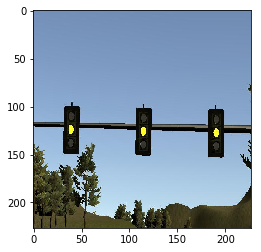

In [16]:
images, labels = next(validation_generator)

print(len(labels))

sample_index = 4
plt.figure()
plt.imshow(images[sample_index])
print(model_final.predict(np.array([images[sample_index]])))

### Correctly identifies as red with 0.53% 

[[  2.91613117e-03   5.30599475e-01   3.19602608e-04   4.66164798e-01]]


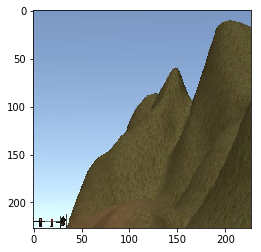

In [17]:
sample_index = 8
plt.figure()
plt.imshow(images[sample_index])
print(model_final.predict(np.array([images[sample_index]])))